## 95891 Homework 3 - Computer Vision 

### Objective : To implement a neural network to classify flowers into 102 categories using AlexNet and Convolutional Neural Nets in PyTorch framework


Steps involved : 
- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve

In [1]:
#load required libraries
import matplotlib.pyplot as plt
import copy
from copy import deepcopy

import torch
from torchvision import datasets,models,transforms
from torch import nn, optim
from collections import OrderedDict


#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [2]:
#declare data directory
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


#### 1.2. Preview some images
Use PIL library to preview images

(523, 500)


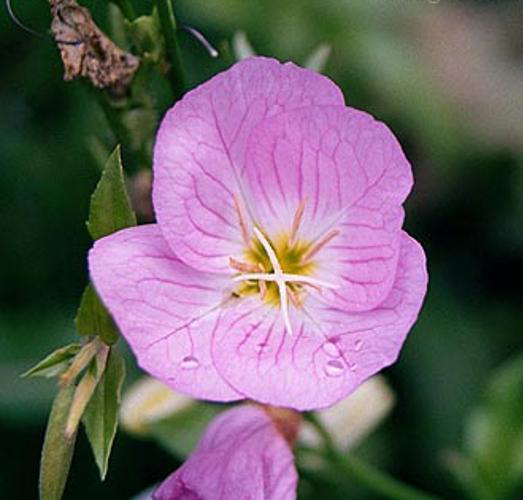

In [3]:

from PIL import Image  #show one example of image

Img = Image.open("flowers/train/1/image_06734.jpg")
print(Img.size)

Image.open("flowers/train/1/image_06734.jpg")

#### 1.3. Data transformation and processing

In [16]:
#Define transforms 
# Process with some data transformation
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}

# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

training_len = len(dataloaders['training'])
testing_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])


class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)


We have  26 batches of training images; each with 256 images
We have  4 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


### *Question 1: What is the effect of random flip and rotation in image data transformation?*
- How does it impact the training?
#### Ans. Random flip and rotation of image data helps to artificially inflate the size of the training data. This helps in adding variation and combatting the problem of overfitting. It will also help the model learn images from unexpected orientations of images.


- Why do not we apply them randomly at the validation or test time?
#### Ans. The purpose of data augmentation is to improve the model. There is no point of applying them randomly during test or validation since neither of these are meant to improve the model performance. Validation is only to ascertain the best set of hyperparameters for a given model and testing is only to evaluate the final model performance on unseen data.

### *Question 2: Explain the meaning of these numbers for a single batch?*
- 256: This number corresponds to the number of images that are fed into training at a time. If we feed in all the images at once, training would become very slow and a lot of memory consumption would occur.
- 3: The number of channels that are present in the image. Here, they are Red, Green and Blue, hence the number 3. For a Grayscale image, this number would be 1. 
- 224: This is the image height for the batch.
- 224: This is the image widhth for the batch. 

#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown below
![picture](https://drive.google.com/uc?export=view&id=1XG8ZPxxcaOTaniTm-s_FdK4iRJbdMkhA)

Image credit: https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [5]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

In [6]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 1.5. Update the classifier of the model to be compatible with our datasets

In [7]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)
in_features = model.classifier[1].in_features
print(in_features)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(in_features, hidden_units)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, 102)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

9216


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.
#### Ans. To reduce the dependency of the model on any single neuron or a single feature, the hidden units in a layer can be turned off or on with a probability specified by us. This way, the model will become more robust and will be able to generalize better, even when a certain feature is not available or difficult to learn. It helps combat overfitting.


- How does the dropout layer work during the prediction (evaluation) stage?
#### Ans. During the prediction stage, weights of the network will give a larger value when compared to training, since nodes that were unavailable during training would become available during test. Hence, to ensure that the predictions are not distorted, the weights are scaled by the probability with which dropout was done during training. The rescaled weight are used to make the predictions.

In [9]:
#set up model parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.NLLLoss() # this is the loss
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)
print_every = 5
epochs = 30


In [10]:
#training
validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):
    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0
    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):
          # Moving images & labels to the GPU if there is one
        images = images.to(device)
        labels = labels.to(device)
        
        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()
        
        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()
        
        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('Epoch:', e, 'Batch:', batch_idx)
            print('Training loss per batch:', train_batch_loss)
            print('Training accuracy per batch:', train_batch_accuracy.item())
            
    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = copy.deepcopy(model.state_dict())

    # Summary statistic per epoch
    print('Epoch : ', e, 'Summary ')
    print('Avg training loss per epoch :', training_loss / training_len)
    print('Avg training accuracy per epoch :', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)
    

    print('Avg validation loss per epoch : ', validation_loss / validation_len)
    print('Avg validation accuracy per epoch : ',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()
        

    

Epoch: 0 Batch: 0
Training loss per batch: 4.818760871887207
Training accuracy per batch: 0.0
Epoch: 0 Batch: 5
Training loss per batch: 13.970025062561035
Training accuracy per batch: 0.0625
Epoch: 0 Batch: 10
Training loss per batch: 10.52915096282959
Training accuracy per batch: 0.08203125
Epoch: 0 Batch: 15
Training loss per batch: 4.153903484344482
Training accuracy per batch: 0.203125
Epoch: 0 Batch: 20
Training loss per batch: 3.12561297416687
Training accuracy per batch: 0.296875
Epoch: 0 Batch: 25
Training loss per batch: 2.9983620643615723
Training accuracy per batch: 0.2763157784938812
Epoch :  0 Summary 
Avg training loss per epoch : 8.235342777692354
Avg training accuracy per epoch : 0.1429893087882262
Avg validation loss per epoch :  2.1602593660354614
Avg validation accuracy per epoch :  0.503789059817791

Epoch: 1 Batch: 0
Training loss per batch: 2.794558525085449
Training accuracy per batch: 0.34765625
Epoch: 1 Batch: 5
Training loss per batch: 2.6197569370269775
Trai

Epoch :  9 Summary 
Avg training loss per epoch : 1.0860927723921263
Avg training accuracy per epoch : 0.7020100584396949
Avg validation loss per epoch :  0.44939372688531876
Avg validation accuracy per epoch :  0.8751562535762787

Epoch: 10 Batch: 0
Training loss per batch: 0.9561612010002136
Training accuracy per batch: 0.734375
Epoch: 10 Batch: 5
Training loss per batch: 1.0144089460372925
Training accuracy per batch: 0.6875
Epoch: 10 Batch: 10
Training loss per batch: 0.968849241733551
Training accuracy per batch: 0.73046875
Epoch: 10 Batch: 15
Training loss per batch: 0.8807657361030579
Training accuracy per batch: 0.75390625
Epoch: 10 Batch: 20
Training loss per batch: 1.0613689422607422
Training accuracy per batch: 0.6796875
Epoch: 10 Batch: 25
Training loss per batch: 1.5721869468688965
Training accuracy per batch: 0.625
Epoch :  10 Summary 
Avg training loss per epoch : 1.0559564393300276
Avg training accuracy per epoch : 0.7098858173076923
Avg validation loss per epoch :  0.4

Epoch: 19 Batch: 15
Training loss per batch: 0.9645750522613525
Training accuracy per batch: 0.73046875
Epoch: 19 Batch: 20
Training loss per batch: 1.1540321111679077
Training accuracy per batch: 0.6953125
Epoch: 19 Batch: 25
Training loss per batch: 0.6508700251579285
Training accuracy per batch: 0.8289473652839661
Epoch :  19 Summary 
Avg training loss per epoch : 0.9201815930696634
Avg training accuracy per epoch : 0.7429703313570756
Avg validation loss per epoch :  0.5112190619111061
Avg validation accuracy per epoch :  0.8651562482118607

Epoch: 20 Batch: 0
Training loss per batch: 0.967007577419281
Training accuracy per batch: 0.73828125
Epoch: 20 Batch: 5
Training loss per batch: 0.7685973048210144
Training accuracy per batch: 0.76171875
Epoch: 20 Batch: 10
Training loss per batch: 0.8581275343894958
Training accuracy per batch: 0.765625
Epoch: 20 Batch: 15
Training loss per batch: 0.9447240829467773
Training accuracy per batch: 0.75390625
Epoch: 20 Batch: 20
Training loss per 

Epoch: 29 Batch: 0
Training loss per batch: 0.925195038318634
Training accuracy per batch: 0.7578125
Epoch: 29 Batch: 5
Training loss per batch: 1.0707474946975708
Training accuracy per batch: 0.73046875
Epoch: 29 Batch: 10
Training loss per batch: 0.768200695514679
Training accuracy per batch: 0.78125
Epoch: 29 Batch: 15
Training loss per batch: 0.6828503012657166
Training accuracy per batch: 0.79296875
Epoch: 29 Batch: 20
Training loss per batch: 0.9285240173339844
Training accuracy per batch: 0.7421875
Epoch: 29 Batch: 25
Training loss per batch: 0.7261605262756348
Training accuracy per batch: 0.8026315569877625
Epoch :  29 Summary 
Avg training loss per epoch : 0.8762407784278576
Avg training accuracy per epoch : 0.7566817425764524
Avg validation loss per epoch :  0.4550173431634903
Avg validation accuracy per epoch :  0.8929687440395355



### *Question 4: Report the best model's validation accuracy*
best_validation_accuracy = 0.8969921916723251

In [11]:
print("Best validation accuracy : " ,best_validation_accuracy/validation_len)

Best validation accuracy :  0.8969921916723251


### 1.7. Draw learning curves

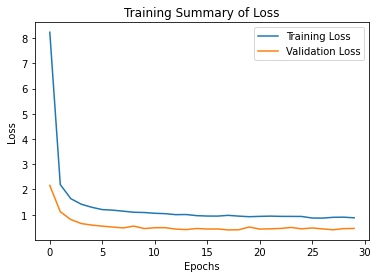

In [12]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

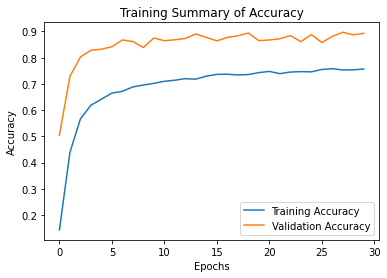

In [13]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Question 5: Briefly describe the plots*
### Plot 1 - Training summary of loss
- We can see that that training and validation loss show a huge decrease in the first few epochs and then stays almost constant, with a very minor decrease. This happens because the model learns better and minimizes loss as the number of epochs increases. 


### Plot 2 : Training summary of accuracy
- We can observe that there is steep increase in validation and training accuracy, followed by the curve becoming almost constant. This is because the model minimizes the loss most on the first few epochs and then starts saturating once it reaches the best possible accuracy.

We can also observe that training accuracy is lesser than validation accuracy and validation loss is less than training loss. So we know that, the model is not overfitting. The model is able to generalize well to unseen data.


### 1.8. Predict on the test data with the best model so far

In [63]:
# Predict on the test data

# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:

    images, labels = images.to(device), labels.to(device)
    log_ps = model(images)
    ps = torch.exp(log_ps)
    prediction, label = ps.topk(1, dim=1)
    predictions.extend(label.detach().numpy())
    label_data.extend(labels.detach().numpy())
    matches = (label == labels.view(*label.shape)).type(
                torch.FloatTensor)
    testing_batch_accuracy = matches.mean()
    test_accuracy += testing_batch_accuracy

print('Test Accuracy:', test_accuracy.item() / testing_len)

Test Accuracy: 0.8542815446853638


### Question 6: Report the test accuracy with the best model
Test Accuracy with the best model - 0.8542

### *Question 7: Provide a confusion matrix between the ground truth and predicted labels in the test dataset. The rows should correspond to the ground ruth categories and the columns to predicted categories. The confusion matrix here should have raw datapoint counts and should not be normalized as percentages*

### *Question 8: Now normalize the raw confusion matrix reported in the previous question by dividing each row by the sum of all its elements. Include this normalized confusion matrix in your report. It may look small but that is fine.*



Confusion Matrix
[[4 0 0 ... 1 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 6]]


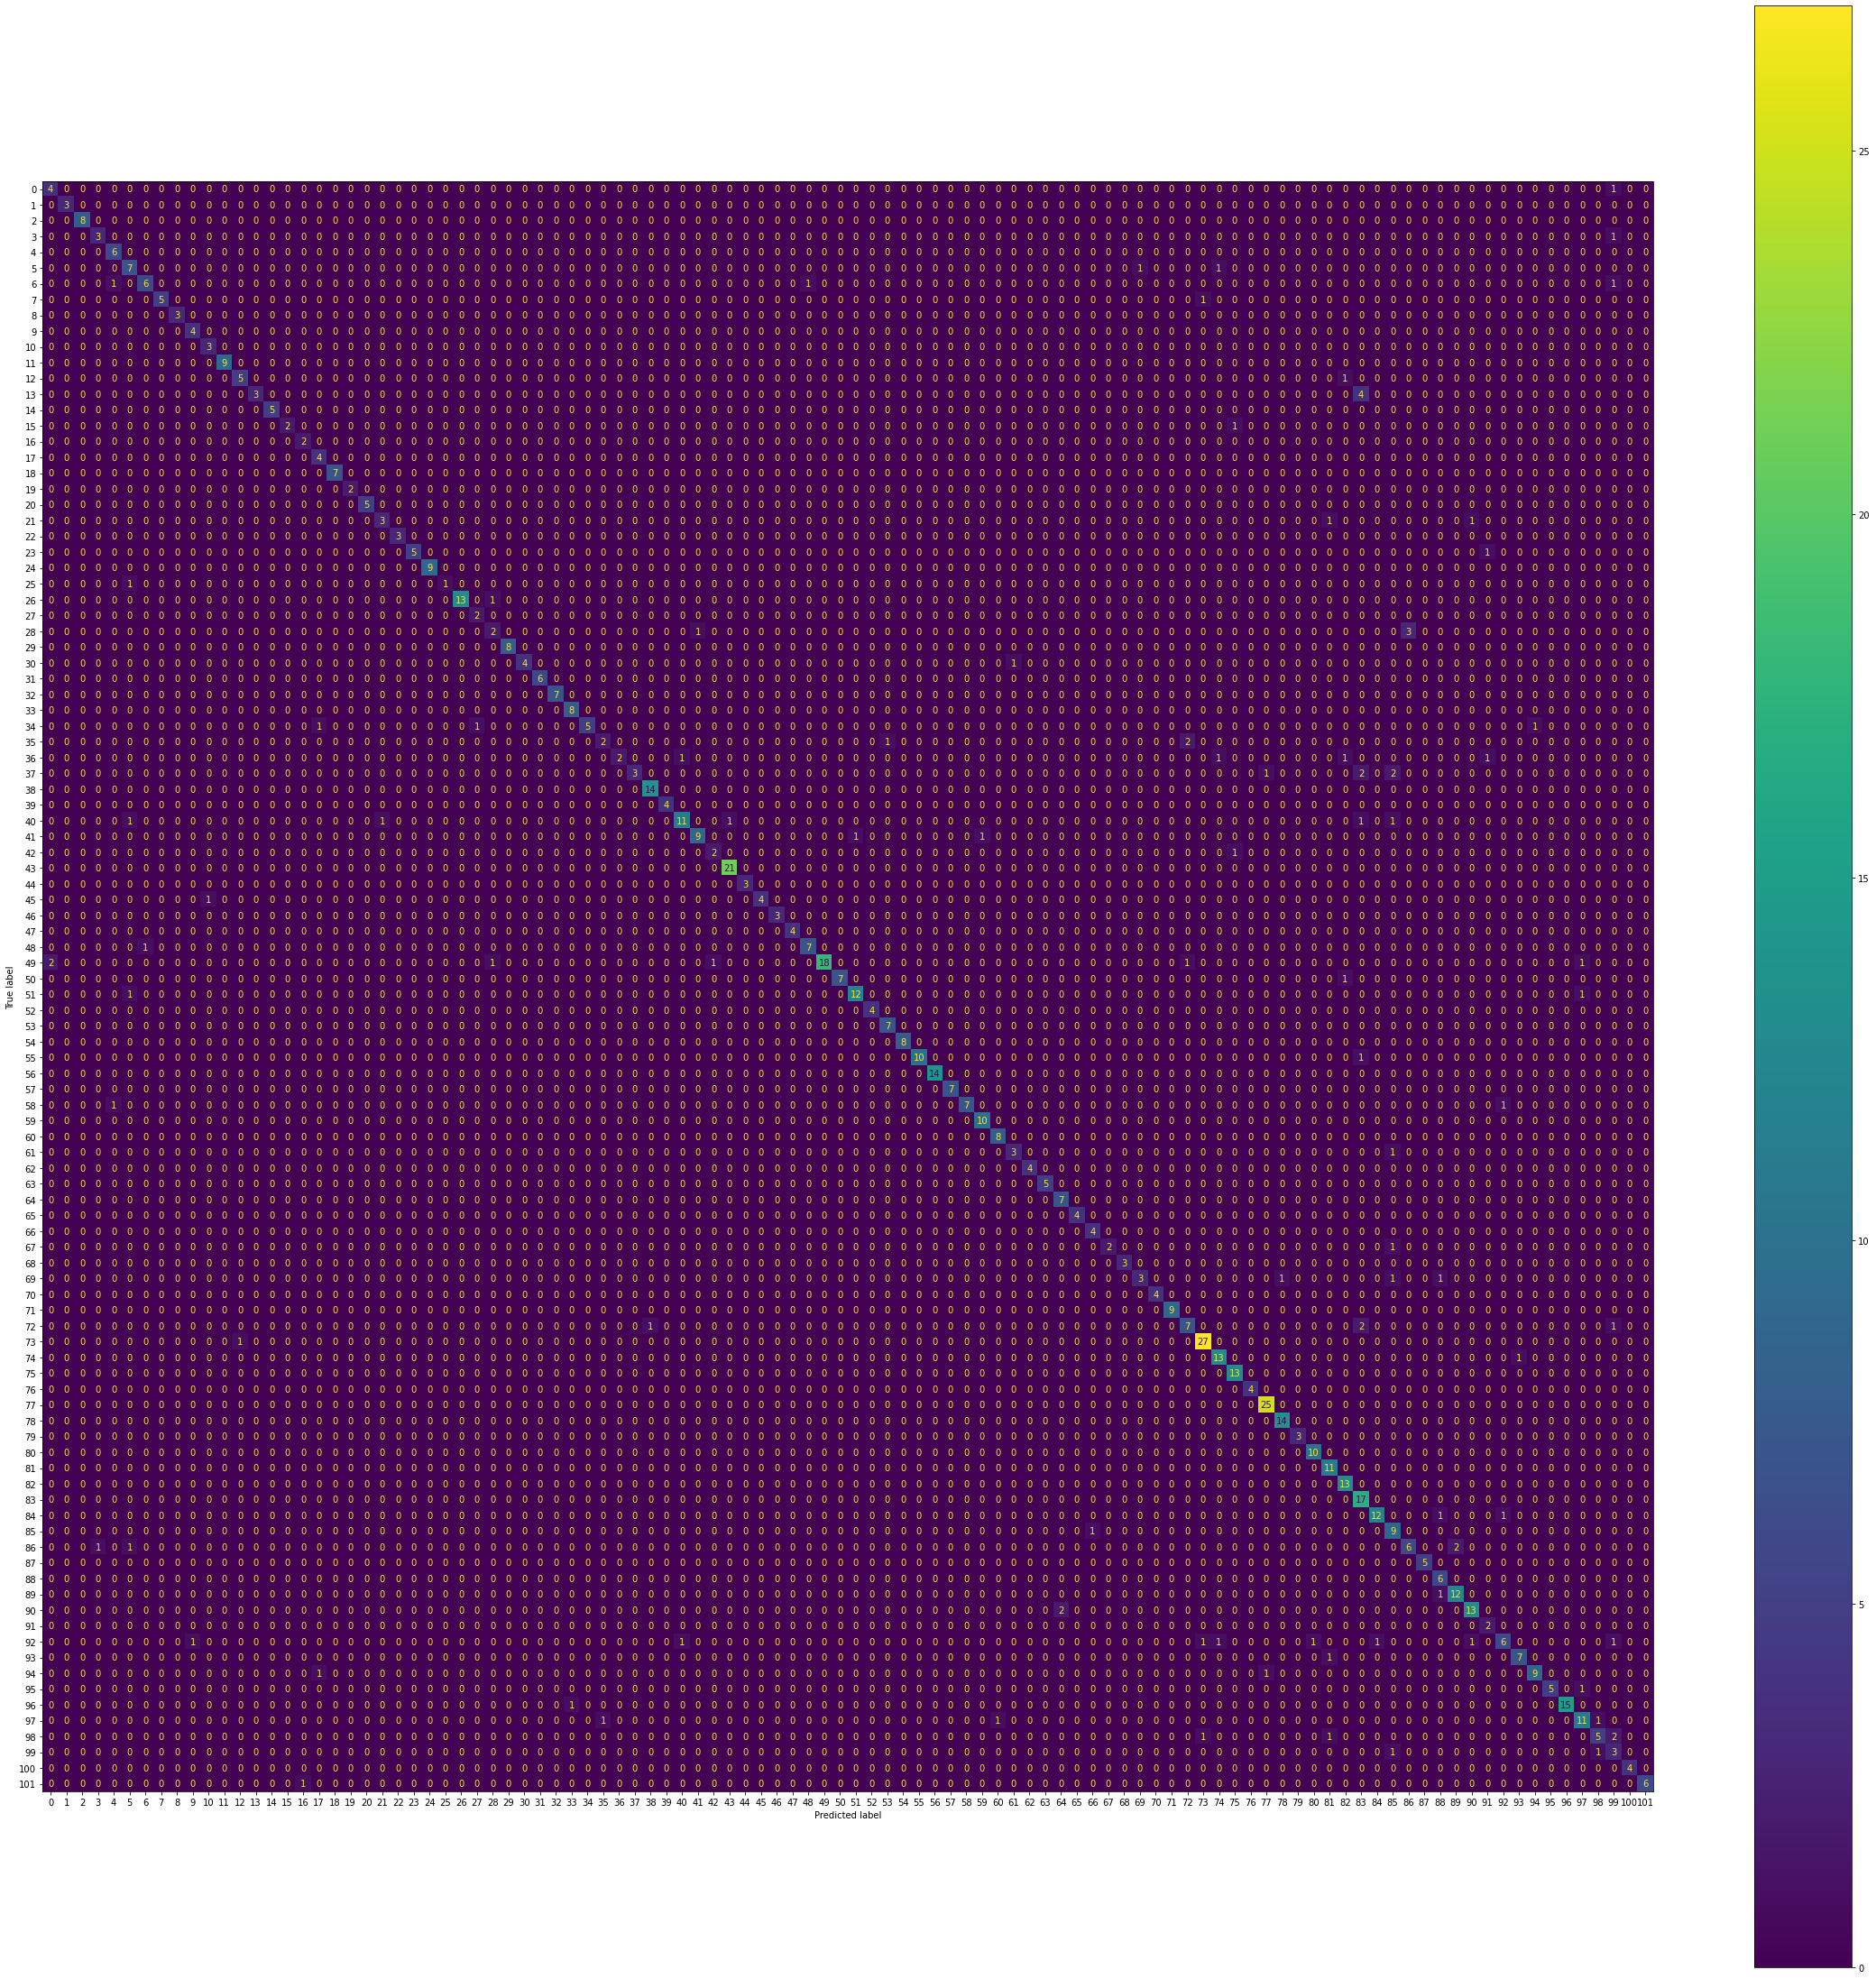

Normalized Confusion Matrix
[[0.8        0.         0.         ... 0.2        0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.6        0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.85714286]]


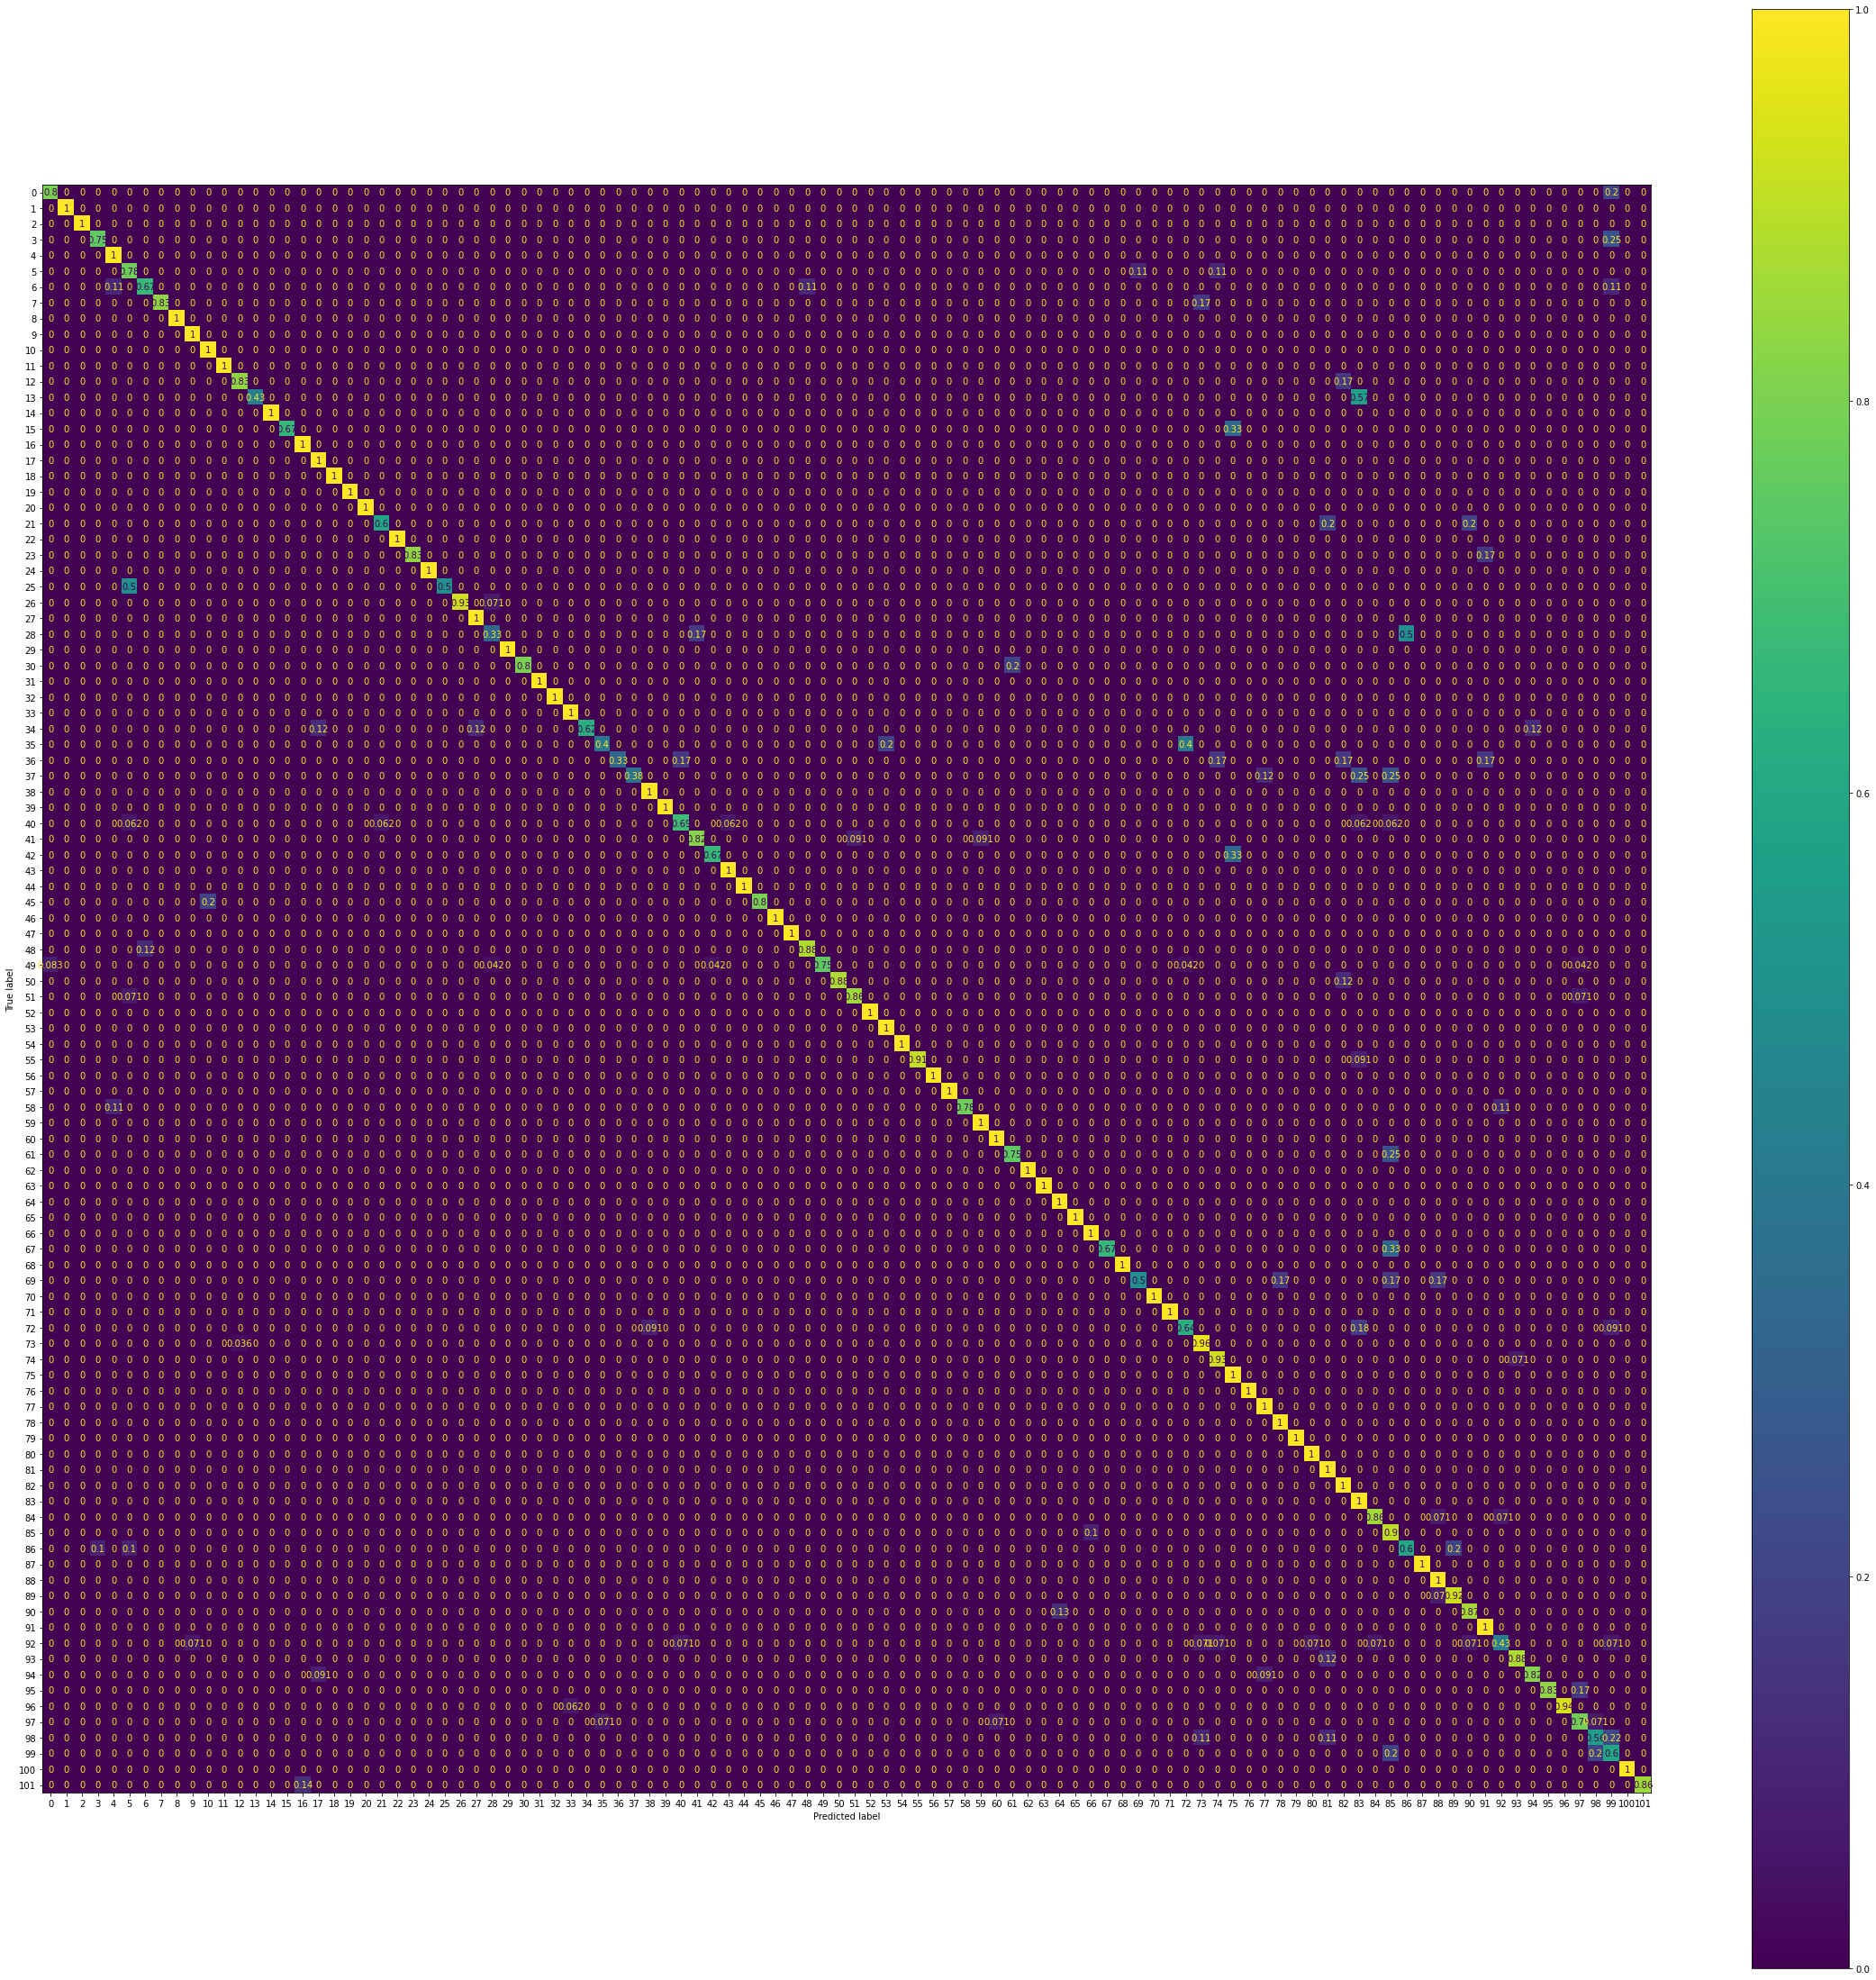

In [83]:
#Question 7 : Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cf = confusion_matrix(label_data,predictions)
print('Confusion Matrix')
print(cf)
disp = ConfusionMatrixDisplay(cf)
fig, ax = plt.subplots(figsize=(40,40))
disp.plot(ax=ax)
plt.show()

#Question 8 : Normalized confusion matrix
print('Normalized Confusion Matrix')
ncf = confusion_matrix(label_data,predictions, normalize = 'true')
print(ncf)
disp = ConfusionMatrixDisplay(ncf)
fig, ax = plt.subplots(figsize=(40,40))
disp.plot(ax=ax)
plt.show()


### *Question 9: What does the diagnal denote in the normalized confusion matrix? What is the meaning of the number in the row 1 column 2?*
- The diagonal elements represent the fraction of points for which the true label equals the predicted label in a normalized matrix. The number in row 1 column 2 represents the fraction of elements that had a true label of 1 and predicted label of 2. In this case, that fraction is zero.

### *Question 10: Transfer Learning*
- What is the purpose of a pretrained model and why should it work?
#### A pre-trained model is one that has been trained previously on a large network with a number of images to identify the weights corresponding to the extraction of certain base elements of an image. This works well because the pre-trained model is generally trained on a very large generic dataset with a huge number of classes. This provides it enough generalization power to extend to any class or task. 




- Why should we freeze the features' gradient in the pretrained model but only update the classifier?
 #### We freeze the gradients because the basic features to be extracted from an image like the edges, slanting lines, curves are all the same for different kind of images. Only the final, fully connected layer is responsible for identification of different classes specific to our model. Hence, we only have to update the classifier.
 
 
 


- What may happen if we do not freeze the features' gradient?
#### If we do not freeze the features' gradient, the model will learn the features for the given image dataset from the scratch and it would end up consuming a lot of time and memory power.